XGBoost Regression - 'real-world' example: NYC Taxi-Fare Predictor

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"conorc2006","key":"c5c5a6382a7d50c022aab991694fc17f"}'}

In [2]:
## Ensure the kaggle.json file is present:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Dec  6 13:27 kaggle.json


In [3]:
## Next, install the Kaggle API client:
!pip install -q kaggle

In [4]:
## The Kaggle API Client expects this file to be ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
## Permissions' change
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 1.56MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 45.7MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 64.0MB/s]
 99% 1.55G/1.56G [00:41<00:00, 45.8MB/s]
100% 1.56G/1.56G [00:41<00:00, 40.2MB/s]


In [7]:
!pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=542646e231c39ebcf2db60b303da14ef4667b933e356022f5004f3d34565e840
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [8]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas_datareader import data

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
# Read data in pandas dataframe:

df_train =  pd.read_csv('/content/train.csv.zip', nrows = 1_000_000, parse_dates=["pickup_datetime"])


In [10]:
# List first rows:

df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
# Format 'pickup_datetime' variable:

df_train['pickup_datetime'] =  pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
df_train['pickup_datetime'].head()

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [12]:
df_train.sort_values(by = 'pickup_datetime').tail() ### June 2015 the final month


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
286276,2015-06-30 23:38:21.0000003,26.5,2015-06-30 23:38:21+00:00,-74.008385,40.711571,-73.884071,40.737385,5
955575,2015-06-30 23:45:57.0000003,4.0,2015-06-30 23:45:57+00:00,-74.002342,40.739819,-74.005829,40.745239,1
915826,2015-06-30 23:48:35.0000005,30.5,2015-06-30 23:48:35+00:00,-73.983826,40.729546,-73.927917,40.661186,2
751350,2015-06-30 23:53:23.0000002,3.5,2015-06-30 23:53:23+00:00,-73.978020,40.757439,-73.980705,40.753544,1
785182,2015-06-30 23:53:49.0000003,7.5,2015-06-30 23:53:49+00:00,-73.959969,40.762405,-73.953064,40.782688,1


In [13]:
# Add time variables:

df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['weekday'] = df_train['pickup_datetime'].dt.weekday
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['year'] = df_train['pickup_datetime'].dt.year


In [14]:
df_train = df_train.drop(['pickup_datetime','key'], axis = 1)
df_train.head()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,2010


In [15]:
# Remove negative fares and postive outliers:

df_train = df_train[df_train.fare_amount>=0]
df_train = df_train[df_train.fare_amount<=60]
print('New size: %d' % len(df_train))

New size: 997297


In [16]:
# Remove missing data:

df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

New size: 997288


In [17]:
# June 2015 NYC taxi data (Wu et al, 2017):

df_train = df_train[df_train.month==6]
df_train = df_train[df_train.year==2015]
print('New size: %d' % len(df_train))

New size: 11269


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


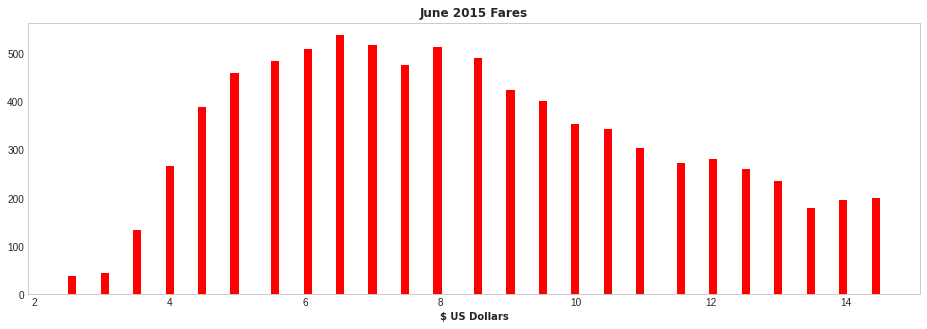

In [18]:
# Histogram fare plot:

df_train[df_train.fare_amount<15].fare_amount.hist(bins=100, figsize=(16,5), color = "red")
plt.xlabel('$ US Dollars', weight = 'bold', family = 'Arial')
plt.title('June 2015 Fares', weight = 'bold', family = 'Arial')
plt.grid(b=None)

In [19]:
y = df_train.fare_amount.values + 1e-10
y ### for supervised learning: output vector y

array([22.54,  8.  , 34.  , ...,  4.5 ,  6.5 ,  7.  ])

In [20]:
# List first rows (post-cleaning):

df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
31,22.54,-74.010483,40.717667,-73.985771,40.660366,1,21,6,6,2015
310,8.00,-74.010727,40.710091,-73.998100,40.722900,1,9,5,6,2015
314,34.00,-73.974899,40.751095,-73.908546,40.881878,0,23,1,6,2015
321,8.00,-73.961784,40.759579,-73.978943,40.772606,4,21,0,6,2015
486,11.50,-73.957443,40.761703,-73.973236,40.787079,1,19,0,6,2015


In [21]:
X = df_train.drop(['fare_amount', 'month', 'year'], axis = 1)
X.head() ### for supervised learning: input matrix X

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday
31,-74.010483,40.717667,-73.985771,40.660366,1,21,6
310,-74.010727,40.710091,-73.998100,40.722900,1,9,5
314,-73.974899,40.751095,-73.908546,40.881878,0,23,1
321,-73.961784,40.759579,-73.978943,40.772606,4,21,0
486,-73.957443,40.761703,-73.973236,40.787079,1,19,0


In [22]:
### Optimum rmse: regression model objective function is Root Mean Square Error (RMSE); 
### Should be minimized (as close to zero as possible):

y_global_orig = 0

In [23]:
### Bayesian Optimization - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points

util_approx = 'ExpectedImprovement'
util_exact = 'dEI_GP'
n_init = 5 # random initialisations
opt = True

test_perc = 0.667
train_perc = 1 - test_perc

n_test = int(len(df_train) * test_perc)
n_train = int(len(df_train) - n_test)

eps = 1e-08

In [24]:
### Objective function:

if obj_func == 'XGBoost': # 6-D
            
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    dim = 6
    
    max_iter = 30  # iterations of Bayesian optimization
    
    operator = 1 
    
    n_est = 3

In [25]:
n_start_AcqFunc = max_iter


In [26]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [27]:
### Set-seeds:

run_num_1 = 0
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [28]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
    

In [29]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [30]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [31]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [32]:
start_approx = time.time()
start_approx

1638797439.0563183

In [33]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_approx), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_1 = approx_1.getResult()[0]
params_approx_1['max_depth'] = int(params_approx_1['max_depth'])
params_approx_1['min_child_weight'] = int(params_approx_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train1 = xgb.DMatrix(X_train1, y_train1)
dX_approx_test1 = xgb.DMatrix(X_test1, y_test1)
model_approx_1 = xgb.train(params_approx_1, dX_approx_train1)
pred_approx_1 = model_approx_1.predict(dX_approx_test1)

rmse_approx_1 = np.sqrt(mean_squared_error(pred_approx_1, y_test1))
rmse_approx_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.48813504 7.15189366 8.         0.92897281 8.         0.48128932]. 	  -0.5626915313589341 	 -0.46143572360276275
init   	 [ 6.45894113  4.37587211 11.          0.52835649 13.          0.44509737]. 	  -0.5772881365468763 	 -0.46143572360276275
init   	 [ 7.91725038  5.2889492  13.          0.6963924  14.          0.40365654]. 	  -0.5870544636272766 	 -0.46143572360276275
init   	 [ 6.48171872  3.6824154  10.          0.88907838 16.          0.88307853]. 	  -0.46143572360276275 	 -0.46143572360276275
init   	 [4.73608045 8.00910752 8.         0.83943977 8.         0.67592892]. 	  -0.5051288806760134 	 -0.46143572360276275
1      	 [ 0.96098408  9.76459465  7.          0.75481219 17.          0.64436097]. 	  -0.5149059967458438 	 -0.46143572360276275
2      	 [ 0.25662718  2.07470075 13.          0.86522109  6.          0.51721788]. 	  -0.5609779944418447 	 -0.46143572360276275
3      	 [ 9.79573252  1.48478088 12.      

5.196570486148013

In [34]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_approx), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_2 = approx_2.getResult()[0]
params_approx_2['max_depth'] = int(params_approx_2['max_depth'])
params_approx_2['min_child_weight'] = int(params_approx_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train2 = xgb.DMatrix(X_train2, y_train2)
dX_approx_test2 = xgb.DMatrix(X_test2, y_test2)
model_approx_2 = xgb.train(params_approx_2, dX_approx_train2)
pred_approx_2 = model_approx_2.predict(dX_approx_test2)

rmse_approx_2 = np.sqrt(mean_squared_error(pred_approx_2, y_test2))
rmse_approx_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]. 	  -0.5147867600449749 	 -0.4765694615523879
init   	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]. 	  -0.4765694615523879 	 -0.4765694615523879
init   	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]. 	  -0.4946399399702889 	 -0.4765694615523879
init   	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]. 	  -0.5884370816585467 	 -0.4765694615523879
init   	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]. 	  -0.584982798458911 	 -0.4765694615523879
1      	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]. 	  -0.47692913742153503 	 -0.4765694615523879
2      	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]. 	  -0.42932966844762255 	 -0.42932966844762255
3      	 [ 3.86971225  8.36249195 14.      

4.681223914959444

In [35]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_approx), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_3 = approx_3.getResult()[0]
params_approx_3['max_depth'] = int(params_approx_3['max_depth'])
params_approx_3['min_child_weight'] = int(params_approx_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train3 = xgb.DMatrix(X_train3, y_train3)
dX_approx_test3 = xgb.DMatrix(X_test3, y_test3)
model_approx_3 = xgb.train(params_approx_3, dX_approx_train3)
pred_approx_3 = model_approx_3.predict(dX_approx_test3)

rmse_approx_3 = np.sqrt(mean_squared_error(pred_approx_3, y_test3))
rmse_approx_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]. 	  -0.7165783188757435 	 -0.6409647951145182
init   	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]. 	  -0.7204431346766296 	 -0.6409647951145182
init   	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]. 	  -0.6409647951145182 	 -0.6409647951145182
init   	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]. 	  -0.7214290072967551 	 -0.6409647951145182
init   	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]. 	  -0.6558401549443296 	 -0.6409647951145182
1      	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]. 	  -0.652766690473656 	 -0.6409647951145182
2      	 [ 7.69133691  0.25025283 10.          0.52101543 12.          0.10383979]. 	  -0.7148542073105238 	 -0.6409647951145182
3      	 [ 7.38032831  9.94067232 11.         

4.649527586702978

In [36]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_approx), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_4 = approx_4.getResult()[0]
params_approx_4['max_depth'] = int(params_approx_4['max_depth'])
params_approx_4['min_child_weight'] = int(params_approx_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train4 = xgb.DMatrix(X_train4, y_train4)
dX_approx_test4 = xgb.DMatrix(X_test4, y_test4)
model_approx_4 = xgb.train(params_approx_4, dX_approx_train4)
pred_approx_4 = model_approx_4.predict(dX_approx_test4)

rmse_approx_4 = np.sqrt(mean_squared_error(pred_approx_4, y_test4))
rmse_approx_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]. 	  -0.5993772224326677 	 -0.4983304913999733
init   	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]. 	  -0.6069567430422909 	 -0.4983304913999733
init   	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]. 	  -0.7139334307278753 	 -0.4983304913999733
init   	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]. 	  -0.4983304913999733 	 -0.4983304913999733
init   	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]. 	  -0.7091576633146701 	 -0.4983304913999733
1      	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]. 	  -0.7189305559932541 	 -0.4983304913999733
2      	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]. 	  -0.659235838187788 	 -0.4983304913999733
3      	 [ 7.37481669  1.69273565 11.         

5.04081354533672

In [37]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_approx), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_5 = approx_5.getResult()[0]
params_approx_5['max_depth'] = int(params_approx_5['max_depth'])
params_approx_5['min_child_weight'] = int(params_approx_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train5 = xgb.DMatrix(X_train5, y_train5)
dX_approx_test5 = xgb.DMatrix(X_test5, y_test5)
model_approx_5 = xgb.train(params_approx_5, dX_approx_train5)
pred_approx_5 = model_approx_5.predict(dX_approx_test5)

rmse_approx_5 = np.sqrt(mean_squared_error(pred_approx_5, y_test5))
rmse_approx_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]. 	  -0.5323233521622429 	 -0.4868347596133297
init   	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]. 	  -0.4868347596133297 	 -0.4868347596133297
init   	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]. 	  -0.586475577548452 	 -0.4868347596133297
init   	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]. 	  -0.633609225551848 	 -0.4868347596133297
init   	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]. 	  -0.6326249738244012 	 -0.4868347596133297
1      	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]. 	  -0.5882279171378358 	 -0.4868347596133297
2      	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]. 	  -0.6326090413479479 	 -0.4868347596133297
3      	 [ 1.89102498  3.81201457 14.          0.7969

4.826369186532375

In [38]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_approx), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_6 = approx_6.getResult()[0]
params_approx_6['max_depth'] = int(params_approx_6['max_depth'])
params_approx_6['min_child_weight'] = int(params_approx_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train6 = xgb.DMatrix(X_train6, y_train6)
dX_approx_test6 = xgb.DMatrix(X_test6, y_test6)
model_approx_6 = xgb.train(params_approx_6, dX_approx_train6)
pred_approx_6 = model_approx_6.predict(dX_approx_test6)

rmse_approx_6 = np.sqrt(mean_squared_error(pred_approx_6, y_test6))
rmse_approx_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  -0.5719256944003751 	 -0.5405445954433028
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  -0.6047098118480896 	 -0.5405445954433028
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  -0.5405445954433028 	 -0.5405445954433028
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  -0.5678490550489279 	 -0.5405445954433028
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  -0.6145131146454834 	 -0.5405445954433028
1      	 [ 2.83859384  1.8954219   7.          0.66740302 13.          0.2701964 ]. 	  -0.691031094679315 	 -0.5405445954433028
2      	 [ 8.38264396  7.97650716 14.          0.82584689  4.          0.25017455]. 	  -0.6923819935110469 	 -0.5405445954433028
3      	 [8.90357673 8.23982464 5.         0.66456142 9.  

4.5446374171749735

In [39]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_approx), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_7 = approx_7.getResult()[0]
params_approx_7['max_depth'] = int(params_approx_7['max_depth'])
params_approx_7['min_child_weight'] = int(params_approx_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train7 = xgb.DMatrix(X_train7, y_train7)
dX_approx_test7 = xgb.DMatrix(X_test7, y_test7)
model_approx_7 = xgb.train(params_approx_7, dX_approx_train7)
pred_approx_7 = model_approx_7.predict(dX_approx_test7)

rmse_approx_7 = np.sqrt(mean_squared_error(pred_approx_7, y_test7))
rmse_approx_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]. 	  -0.44500885348659536 	 -0.44173641078261416
init   	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]. 	  -0.4488374676936292 	 -0.44173641078261416
init   	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]. 	  -0.5669653799025498 	 -0.44173641078261416
init   	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]. 	  -0.4661284696195417 	 -0.44173641078261416
init   	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]. 	  -0.44173641078261416 	 -0.44173641078261416
1      	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]. 	  -0.5720117286339644 	 -0.44173641078261416
2      	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]. 	  -0.5040023079321674 	 -0.44173641078261416
3      	 [ 8.97988092  8.79483413 14.          0

4.499924380514474

In [40]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_approx), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_8 = approx_8.getResult()[0]
params_approx_8['max_depth'] = int(params_approx_8['max_depth'])
params_approx_8['min_child_weight'] = int(params_approx_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train8 = xgb.DMatrix(X_train8, y_train8)
dX_approx_test8 = xgb.DMatrix(X_test8, y_test8)
model_approx_8 = xgb.train(params_approx_8, dX_approx_train8)
pred_approx_8 = model_approx_8.predict(dX_approx_test8)

rmse_approx_8 = np.sqrt(mean_squared_error(pred_approx_8, y_test8))
rmse_approx_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  -0.5450023023990902 	 -0.47785117417083445
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  -0.48415390639601685 	 -0.47785117417083445
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  -0.5514374023096014 	 -0.47785117417083445
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  -0.509390123714371 	 -0.47785117417083445
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  -0.47785117417083445 	 -0.47785117417083445
1      	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]. 	  -0.4933129789895931 	 -0.47785117417083445
2      	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]. 	  -0.6339615084112526 	 -0.47785117417083445
3      	 [ 9.08237751  2.49680746  6.

4.5410977772226735

In [41]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_approx), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_9 = approx_9.getResult()[0]
params_approx_9['max_depth'] = int(params_approx_9['max_depth'])
params_approx_9['min_child_weight'] = int(params_approx_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train9 = xgb.DMatrix(X_train9, y_train9)
dX_approx_test9 = xgb.DMatrix(X_test9, y_test9)
model_approx_9 = xgb.train(params_approx_9, dX_approx_train9)
pred_approx_9 = model_approx_9.predict(dX_approx_test9)

rmse_approx_9 = np.sqrt(mean_squared_error(pred_approx_9, y_test9))
rmse_approx_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]. 	  -0.6545930802207814 	 -0.4584168030068045
init   	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]. 	  -0.7166132091943936 	 -0.4584168030068045
init   	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]. 	  -0.4584168030068045 	 -0.4584168030068045
init   	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]. 	  -0.48839211091816903 	 -0.4584168030068045
init   	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]. 	  -0.46354466019784824 	 -0.4584168030068045
1      	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]. 	  -0.7145926373770018 	 -0.4584168030068045
2      	 [ 8.16285902  8.43489929  9.          0.96605421 10.          0.79940153]. 	  -0.48073960577713015 	 -0.4584168030068045
3      	 [ 3.67545472  4.78145311 14.     

4.635844534922092

In [42]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_approx), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_10 = approx_10.getResult()[0]
params_approx_10['max_depth'] = int(params_approx_10['max_depth'])
params_approx_10['min_child_weight'] = int(params_approx_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train10 = xgb.DMatrix(X_train10, y_train10)
dX_approx_test10 = xgb.DMatrix(X_test10, y_test10)
model_approx_10 = xgb.train(params_approx_10, dX_approx_train10)
pred_approx_10 = model_approx_10.predict(dX_approx_test10)

rmse_approx_10 = np.sqrt(mean_squared_error(pred_approx_10, y_test10))
rmse_approx_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]. 	  -0.7090674967614334 	 -0.4737745634473992
init   	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]. 	  -0.4737745634473992 	 -0.4737745634473992
init   	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]. 	  -0.4755277191484213 	 -0.4737745634473992
init   	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]. 	  -0.48811859212530173 	 -0.4737745634473992
init   	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]. 	  -0.7057210222477256 	 -0.4737745634473992
1      	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]. 	  -0.46336171949490257 	 -0.46336171949490257
2      	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]. 	  -0.5661654396843121 	 -0.46336171949490257
3      	 [ 2.20772511  4.37663949 11.          

4.70472629125407

In [43]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_approx), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_11 = approx_11.getResult()[0]
params_approx_11['max_depth'] = int(params_approx_11['max_depth'])
params_approx_11['min_child_weight'] = int(params_approx_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train11 = xgb.DMatrix(X_train11, y_train11)
dX_approx_test11 = xgb.DMatrix(X_test11, y_test11)
model_approx_11 = xgb.train(params_approx_11, dX_approx_train11)
pred_approx_11 = model_approx_11.predict(dX_approx_test11)

rmse_approx_11 = np.sqrt(mean_squared_error(pred_approx_11, y_test11))
rmse_approx_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]. 	  -0.5922349044250168 	 -0.49898623219170346
init   	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]. 	  -0.49898623219170346 	 -0.49898623219170346
init   	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]. 	  -0.5404544349803458 	 -0.49898623219170346
init   	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]. 	  -0.5108833748715963 	 -0.49898623219170346
init   	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]. 	  -0.5545314939891337 	 -0.49898623219170346
1      	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]. 	  -0.5252491147925742 	 -0.49898623219170346
2      	 [ 3.00661074  5.9321586  13.          0.93375268  7.          0.32533139]. 	  -0.5712265807436425 	 -0.49898623219170346
3      	 [2.53182769 2.77763325 5.   

4.76903438463805

In [44]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_approx), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_12 = approx_12.getResult()[0]
params_approx_12['max_depth'] = int(params_approx_12['max_depth'])
params_approx_12['min_child_weight'] = int(params_approx_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train12 = xgb.DMatrix(X_train12, y_train12)
dX_approx_test12 = xgb.DMatrix(X_test12, y_test12)
model_approx_12 = xgb.train(params_approx_12, dX_approx_train12)
pred_approx_12 = model_approx_12.predict(dX_approx_test12)

rmse_approx_12 = np.sqrt(mean_squared_error(pred_approx_12, y_test12))
rmse_approx_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]. 	  -0.6840535846029854 	 -0.5032799564384677
init   	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]. 	  -0.6305456734924068 	 -0.5032799564384677
init   	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]. 	  -0.6144010633484512 	 -0.5032799564384677
init   	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]. 	  -0.5032799564384677 	 -0.5032799564384677
init   	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]. 	  -0.6516977337723864 	 -0.5032799564384677
1      	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]. 	  -0.5227768283895782 	 -0.5032799564384677
2      	 [ 7.57473716  9.63637997 12.          0.83444517 10.          0.18761713]. 	  -0.6734912089891107 	 -0.5032799564384677
3      	 [ 9.04517621  0.80881017 13.          0.96

5.3480467281598605

In [45]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_approx), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_13 = approx_13.getResult()[0]
params_approx_13['max_depth'] = int(params_approx_13['max_depth'])
params_approx_13['min_child_weight'] = int(params_approx_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train13 = xgb.DMatrix(X_train13, y_train13)
dX_approx_test13 = xgb.DMatrix(X_test13, y_test13)
model_approx_13 = xgb.train(params_approx_13, dX_approx_train13)
pred_approx_13 = model_approx_13.predict(dX_approx_test13)

rmse_approx_13 = np.sqrt(mean_squared_error(pred_approx_13, y_test13))
rmse_approx_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]. 	  -0.5099204187421568 	 -0.5099204187421568
init   	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]. 	  -0.7086153631136594 	 -0.5099204187421568
init   	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]. 	  -0.6372461781857162 	 -0.5099204187421568
init   	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]. 	  -0.5702017504451442 	 -0.5099204187421568
init   	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]. 	  -0.7101125715665313 	 -0.5099204187421568
1      	 [1.1119361  5.43221306 6.         0.56899303 8.         0.32100319]. 	  -0.6493427493033831 	 -0.5099204187421568
2      	 [ 6.78607938  6.56608561 12.          0.84765686  1.          0.65153116]. 	  -0.587676594976195 	 -0.5099204187421568
3      	 [ 9.24780874  8.51103418  5.         

4.922006581447384

In [46]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_approx), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_14 = approx_14.getResult()[0]
params_approx_14['max_depth'] = int(params_approx_14['max_depth'])
params_approx_14['min_child_weight'] = int(params_approx_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train14 = xgb.DMatrix(X_train14, y_train14)
dX_approx_test14 = xgb.DMatrix(X_test14, y_test14)
model_approx_14 = xgb.train(params_approx_14, dX_approx_train14)
pred_approx_14 = model_approx_14.predict(dX_approx_test14)

rmse_approx_14 = np.sqrt(mean_squared_error(pred_approx_14, y_test14))
rmse_approx_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]. 	  -0.558794499921046 	 -0.4448140077853999
init   	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]. 	  -0.49979629433789113 	 -0.4448140077853999
init   	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]. 	  -0.5741697988899073 	 -0.4448140077853999
init   	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]. 	  -0.4448140077853999 	 -0.4448140077853999
init   	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]. 	  -0.6214151152359092 	 -0.4448140077853999
1      	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]. 	  -0.6294794339238933 	 -0.4448140077853999
2      	 [ 9.16780803  5.31613214 10.          0.57182868  6.          0.98158575]. 	  -0.45924355274685935 	 -0.4448140077853999
3      	 [0.07739536 3.94062842 5.         0

4.728867098394265

In [47]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_approx), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_15 = approx_15.getResult()[0]
params_approx_15['max_depth'] = int(params_approx_15['max_depth'])
params_approx_15['min_child_weight'] = int(params_approx_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train15 = xgb.DMatrix(X_train15, y_train15)
dX_approx_test15 = xgb.DMatrix(X_test15, y_test15)
model_approx_15 = xgb.train(params_approx_15, dX_approx_train15)
pred_approx_15 = model_approx_15.predict(dX_approx_test15)

rmse_approx_15 = np.sqrt(mean_squared_error(pred_approx_15, y_test15))
rmse_approx_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]. 	  -0.489437914006383 	 -0.489437914006383
init   	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]. 	  -0.6992441679399787 	 -0.489437914006383
init   	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]. 	  -0.69945028775584 	 -0.489437914006383
init   	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]. 	  -0.6264981748624211 	 -0.489437914006383
init   	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]. 	  -0.6964615643692806 	 -0.489437914006383
1      	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]. 	  -0.56524595824364 	 -0.489437914006383
2      	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]. 	  -0.6976766501007658 	 -0.489437914006383
3      	 [ 1.91126037  0.99517267  5.          0.54111286 13.  

4.570230628583621

In [48]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_approx), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_16 = approx_16.getResult()[0]
params_approx_16['max_depth'] = int(params_approx_16['max_depth'])
params_approx_16['min_child_weight'] = int(params_approx_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train16 = xgb.DMatrix(X_train16, y_train16)
dX_approx_test16 = xgb.DMatrix(X_test16, y_test16)
model_approx_16 = xgb.train(params_approx_16, dX_approx_train16)
pred_approx_16 = model_approx_16.predict(dX_approx_test16)

rmse_approx_16 = np.sqrt(mean_squared_error(pred_approx_16, y_test16))
rmse_approx_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]. 	  -0.6357813258069683 	 -0.6345701590947206
init   	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]. 	  -0.7029752724132097 	 -0.6345701590947206
init   	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]. 	  -0.6345701590947206 	 -0.6345701590947206
init   	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]. 	  -0.7076230970293895 	 -0.6345701590947206
init   	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]. 	  -0.7061563820165734 	 -0.6345701590947206
1      	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]. 	  -0.5498317738591506 	 -0.5498317738591506
2      	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]. 	  -0.5694622631948656 	 -0.5498317738591506
3      	 [ 9.80741348  8.90144788 14.          0.82

4.766669679411465

In [49]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_approx), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_17 = approx_17.getResult()[0]
params_approx_17['max_depth'] = int(params_approx_17['max_depth'])
params_approx_17['min_child_weight'] = int(params_approx_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train17 = xgb.DMatrix(X_train17, y_train17)
dX_approx_test17 = xgb.DMatrix(X_test17, y_test17)
model_approx_17 = xgb.train(params_approx_17, dX_approx_train17)
pred_approx_17 = model_approx_17.predict(dX_approx_test17)

rmse_approx_17 = np.sqrt(mean_squared_error(pred_approx_17, y_test17))
rmse_approx_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]. 	  -0.48092361225642916 	 -0.48092361225642916
init   	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]. 	  -0.634455605137701 	 -0.48092361225642916
init   	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]. 	  -0.6046684392629649 	 -0.48092361225642916
init   	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]. 	  -0.6562801618178493 	 -0.48092361225642916
init   	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]. 	  -0.6415104035419145 	 -0.48092361225642916
1      	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]. 	  -0.6424064809093688 	 -0.48092361225642916
2      	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]. 	  -0.5250563773138615 	 -0.48092361225642916
3      	 [0.65992542 7.03112384 5.         0

4.654967820847159

In [50]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_approx), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_18 = approx_18.getResult()[0]
params_approx_18['max_depth'] = int(params_approx_18['max_depth'])
params_approx_18['min_child_weight'] = int(params_approx_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train18 = xgb.DMatrix(X_train18, y_train18)
dX_approx_test18 = xgb.DMatrix(X_test18, y_test18)
model_approx_18 = xgb.train(params_approx_18, dX_approx_train18)
pred_approx_18 = model_approx_18.predict(dX_approx_test18)

rmse_approx_18 = np.sqrt(mean_squared_error(pred_approx_18, y_test18))
rmse_approx_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]. 	  -0.6513740959050699 	 -0.4474949996843899
init   	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]. 	  -0.5068571689279089 	 -0.4474949996843899
init   	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]. 	  -0.6466851980958979 	 -0.4474949996843899
init   	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]. 	  -0.5514036168275981 	 -0.4474949996843899
init   	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]. 	  -0.4474949996843899 	 -0.4474949996843899
1      	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]. 	  -0.5562589356787108 	 -0.4474949996843899
2      	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]. 	  -0.4433734006799697 	 -0.4433734006799697
3      	 [ 6.9243088   2.24175244  9.          0.535904  

4.584155970052441

In [51]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_approx), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_19 = approx_19.getResult()[0]
params_approx_19['max_depth'] = int(params_approx_19['max_depth'])
params_approx_19['min_child_weight'] = int(params_approx_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train19 = xgb.DMatrix(X_train19, y_train19)
dX_approx_test19 = xgb.DMatrix(X_test19, y_test19)
model_approx_19 = xgb.train(params_approx_19, dX_approx_train19)
pred_approx_19 = model_approx_19.predict(dX_approx_test19)

rmse_approx_19 = np.sqrt(mean_squared_error(pred_approx_19, y_test19))
rmse_approx_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]. 	  -0.5851081958447377 	 -0.4870287725699859
init   	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]. 	  -0.5245729886945251 	 -0.4870287725699859
init   	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]. 	  -0.677999989539271 	 -0.4870287725699859
init   	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]. 	  -0.4940235599803803 	 -0.4870287725699859
init   	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]. 	  -0.4870287725699859 	 -0.4870287725699859
1      	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]. 	  -0.48699206254226385 	 -0.48699206254226385
2      	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]. 	  -0.5586571006723301 	 -0.48699206254226385
3      	 [ 9.05225624  3.60011377 14.      

4.673966048842431

In [52]:
### Bayesian optimization runs (x20): 'approx' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_approx), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_20 = approx_20.getResult()[0]
params_approx_20['max_depth'] = int(params_approx_20['max_depth'])
params_approx_20['min_child_weight'] = int(params_approx_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train20 = xgb.DMatrix(X_train20, y_train20)
dX_approx_test20 = xgb.DMatrix(X_test20, y_test20)
model_approx_20 = xgb.train(params_approx_20, dX_approx_train20)
pred_approx_20 = model_approx_20.predict(dX_approx_test20)

rmse_approx_20 = np.sqrt(mean_squared_error(pred_approx_20, y_test20))
rmse_approx_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]. 	  -0.4485352768858121 	 -0.4485352768858121
init   	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]. 	  -0.47208091450542966 	 -0.4485352768858121
init   	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]. 	  -0.7316473600840852 	 -0.4485352768858121
init   	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]. 	  -0.7314226542252507 	 -0.4485352768858121
init   	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]. 	  -0.6494230116583573 	 -0.4485352768858121
1      	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]. 	  -0.6502222800629637 	 -0.4485352768858121
2      	 [ 1.72798052  9.03285612 13.          0.50351094 19.          0.11416888]. 	  -0.7324821709443572 	 -0.4485352768858121
3      	 [ 1.96661701  1.73294312 11.       

4.612375814946857

In [53]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1638798047.516459

In [54]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_exact), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_1 = exact_1.getResult()[0]
params_exact_1['max_depth'] = int(params_exact_1['max_depth'])
params_exact_1['min_child_weight'] = int(params_exact_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train1 = xgb.DMatrix(X_train1, y_train1)
dX_exact_test1 = xgb.DMatrix(X_test1, y_test1)
model_exact_1 = xgb.train(params_exact_1, dX_exact_train1)
pred_exact_1 = model_exact_1.predict(dX_exact_test1)

rmse_exact_1 = np.sqrt(mean_squared_error(pred_exact_1, y_test1))
rmse_exact_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.48813504 7.15189366 8.         0.92897281 8.         0.48128932]. 	  -0.5626915313589341 	 -0.46143572360276275
init   	 [ 6.45894113  4.37587211 11.          0.52835649 13.          0.44509737]. 	  -0.5772881365468763 	 -0.46143572360276275
init   	 [ 7.91725038  5.2889492  13.          0.6963924  14.          0.40365654]. 	  -0.5870544636272766 	 -0.46143572360276275
init   	 [ 6.48171872  3.6824154  10.          0.88907838 16.          0.88307853]. 	  -0.46143572360276275 	 -0.46143572360276275
init   	 [4.73608045 8.00910752 8.         0.83943977 8.         0.67592892]. 	  -0.5051288806760134 	 -0.46143572360276275
1      	 [ 0.96098408  9.76459465  7.          0.75481219 17.          0.64436097]. 	  -0.5149059967458438 	 -0.46143572360276275
2      	 [ 0.25662718  2.07470075 13.          0.86522109  6.          0.51721788]. 	  -0.5609779944418447 	 -0.46143572360276275
3      	 [ 9.79573252  1.48478088 12.      

4.552935223808369

In [55]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_exact), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_2 = exact_2.getResult()[0]
params_exact_2['max_depth'] = int(params_exact_2['max_depth'])
params_exact_2['min_child_weight'] = int(params_exact_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train2 = xgb.DMatrix(X_train2, y_train2)
dX_exact_test2 = xgb.DMatrix(X_test2, y_test2)
model_exact_2 = xgb.train(params_exact_2, dX_exact_train2)
pred_exact_2 = model_exact_2.predict(dX_exact_test2)

rmse_exact_2 = np.sqrt(mean_squared_error(pred_exact_2, y_test2))
rmse_exact_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]. 	  -0.5147867600449749 	 -0.4765694615523879
init   	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]. 	  -0.4765694615523879 	 -0.4765694615523879
init   	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]. 	  -0.4946399399702889 	 -0.4765694615523879
init   	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]. 	  -0.5884370816585467 	 -0.4765694615523879
init   	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]. 	  -0.584982798458911 	 -0.4765694615523879
1      	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]. 	  -0.47692913742153503 	 -0.4765694615523879
2      	 [ 2.17907321  8.34965852  5.          0.91660625 18.          0.97349298]. 	  -0.42932966844762255 	 -0.42932966844762255
3      	 [ 3.86971225  8.36249195 14.      

4.681223914959444

In [56]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_exact), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_3 = exact_3.getResult()[0]
params_exact_3['max_depth'] = int(params_exact_3['max_depth'])
params_exact_3['min_child_weight'] = int(params_exact_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train3 = xgb.DMatrix(X_train3, y_train3)
dX_exact_test3 = xgb.DMatrix(X_test3, y_test3)
model_exact_3 = xgb.train(params_exact_3, dX_exact_train3)
pred_exact_3 = model_exact_3.predict(dX_exact_test3)

rmse_exact_3 = np.sqrt(mean_squared_error(pred_exact_3, y_test3))
rmse_exact_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]. 	  -0.7165783188757435 	 -0.6409647951145182
init   	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]. 	  -0.7204431346766296 	 -0.6409647951145182
init   	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]. 	  -0.6409647951145182 	 -0.6409647951145182
init   	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]. 	  -0.7214290072967551 	 -0.6409647951145182
init   	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]. 	  -0.6558401549443296 	 -0.6409647951145182
1      	 [ 4.57686399  8.60533913  5.          0.93553602 12.          0.35017976]. 	  -0.7057140018685644 	 -0.6409647951145182
2      	 [7.88832343 8.95739531 8.         0.70911141 2.         0.87634458]. 	  -0.47297363784462537 	 -0.47297363784462537
3      	 [4.47677412 5.05596963 6.         

4.636425000635952

In [57]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_exact), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_4 = exact_4.getResult()[0]
params_exact_4['max_depth'] = int(params_exact_4['max_depth'])
params_exact_4['min_child_weight'] = int(params_exact_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train4 = xgb.DMatrix(X_train4, y_train4)
dX_exact_test4 = xgb.DMatrix(X_test4, y_test4)
model_exact_4 = xgb.train(params_exact_4, dX_exact_train4)
pred_exact_4 = model_exact_4.predict(dX_exact_test4)

rmse_exact_4 = np.sqrt(mean_squared_error(pred_exact_4, y_test4))
rmse_exact_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]. 	  -0.5993772224326677 	 -0.4983304913999733
init   	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]. 	  -0.6069567430422909 	 -0.4983304913999733
init   	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]. 	  -0.7139334307278753 	 -0.4983304913999733
init   	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]. 	  -0.4983304913999733 	 -0.4983304913999733
init   	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]. 	  -0.7091576633146701 	 -0.4983304913999733
1      	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]. 	  -0.7189305559932541 	 -0.4983304913999733
2      	 [ 0.90674561  6.32290535 11.          0.94435129  1.          0.40346185]. 	  -0.659235838187788 	 -0.4983304913999733
3      	 [ 7.37481669  1.69273565 11.         

5.04081354533672

In [58]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_exact), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_5 = exact_5.getResult()[0]
params_exact_5['max_depth'] = int(params_exact_5['max_depth'])
params_exact_5['min_child_weight'] = int(params_exact_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train5 = xgb.DMatrix(X_train5, y_train5)
dX_exact_test5 = xgb.DMatrix(X_test5, y_test5)
model_exact_5 = xgb.train(params_exact_5, dX_exact_train5)
pred_exact_5 = model_exact_5.predict(dX_exact_test5)

rmse_exact_5 = np.sqrt(mean_squared_error(pred_exact_5, y_test5))
rmse_exact_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]. 	  -0.5323233521622429 	 -0.4868347596133297
init   	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]. 	  -0.4868347596133297 	 -0.4868347596133297
init   	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]. 	  -0.586475577548452 	 -0.4868347596133297
init   	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]. 	  -0.633609225551848 	 -0.4868347596133297
init   	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]. 	  -0.6326249738244012 	 -0.4868347596133297
1      	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]. 	  -0.5882279171378358 	 -0.4868347596133297
2      	 [ 3.90043826  0.30059527 11.          0.95660877 13.          0.16396145]. 	  -0.6326090413479479 	 -0.4868347596133297
3      	 [ 1.89102498  3.81201457 14.          0.7969

4.826369186532375

In [59]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror', eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_exact), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_6 = exact_6.getResult()[0]
params_exact_6['max_depth'] = int(params_exact_6['max_depth'])
params_exact_6['min_child_weight'] = int(params_exact_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train6 = xgb.DMatrix(X_train6, y_train6)
dX_exact_test6 = xgb.DMatrix(X_test6, y_test6)
model_exact_6 = xgb.train(params_exact_6, dX_exact_train6)
pred_exact_6 = model_exact_6.predict(dX_exact_test6)

rmse_exact_6 = np.sqrt(mean_squared_error(pred_exact_6, y_test6))
rmse_exact_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  -0.5719256944003751 	 -0.5405445954433028
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  -0.6047098118480896 	 -0.5405445954433028
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  -0.5405445954433028 	 -0.5405445954433028
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  -0.5678490550489279 	 -0.5405445954433028
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  -0.6145131146454834 	 -0.5405445954433028
1      	 [0.         0.         5.         0.5        9.58451781 0.1       ]. 	  -0.6934569463406091 	 -0.5405445954433028
2      	 [ 8.2078472   3.46309153  6.          0.81837879 15.          0.76382381]. 	  -0.5441749682483966 	 -0.5405445954433028
3      	 [8.90357673 8.23982464 5.         0.66456142 9.       

4.889846993822306

In [60]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_exact), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_7 = exact_7.getResult()[0]
params_exact_7['max_depth'] = int(params_exact_7['max_depth'])
params_exact_7['min_child_weight'] = int(params_exact_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train7 = xgb.DMatrix(X_train7, y_train7)
dX_exact_test7 = xgb.DMatrix(X_test7, y_test7)
model_exact_7 = xgb.train(params_exact_7, dX_exact_train7)
pred_exact_7 = model_exact_7.predict(dX_exact_test7)

rmse_exact_7 = np.sqrt(mean_squared_error(pred_exact_7, y_test7))
rmse_exact_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]. 	  -0.44500885348659536 	 -0.44173641078261416
init   	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]. 	  -0.4488374676936292 	 -0.44173641078261416
init   	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]. 	  -0.5669653799025498 	 -0.44173641078261416
init   	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]. 	  -0.4661284696195417 	 -0.44173641078261416
init   	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]. 	  -0.44173641078261416 	 -0.44173641078261416
1      	 [3.43305102 3.00339076 8.         0.71322679 4.         0.33322219]. 	  -0.5720117286339644 	 -0.44173641078261416
2      	 [ 8.27276329  5.80705371  6.          0.6575149  16.          0.66596626]. 	  -0.5040023079321674 	 -0.44173641078261416
3      	 [ 8.97988092  8.79483413 14.          0

4.499924380514474

In [61]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_exact), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_8 = exact_8.getResult()[0]
params_exact_8['max_depth'] = int(params_exact_8['max_depth'])
params_exact_8['min_child_weight'] = int(params_exact_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train8 = xgb.DMatrix(X_train8, y_train8)
dX_exact_test8 = xgb.DMatrix(X_test8, y_test8)
model_exact_8 = xgb.train(params_exact_8, dX_exact_train8)
pred_exact_8 = model_exact_8.predict(dX_exact_test8)

rmse_exact_8 = np.sqrt(mean_squared_error(pred_exact_8, y_test8))
rmse_exact_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  -0.5450023023990902 	 -0.47785117417083445
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  -0.48415390639601685 	 -0.47785117417083445
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  -0.5514374023096014 	 -0.47785117417083445
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  -0.509390123714371 	 -0.47785117417083445
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  -0.47785117417083445 	 -0.47785117417083445
1      	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]. 	  -0.4933129789895931 	 -0.47785117417083445
2      	 [ 4.42530022  8.86662399 12.          0.55390756 19.          0.26906902]. 	  -0.6339615084112526 	 -0.47785117417083445
3      	 [ 9.08237751  2.49680746  6.

4.797573101898328

In [62]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_exact), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_9 = exact_9.getResult()[0]
params_exact_9['max_depth'] = int(params_exact_9['max_depth'])
params_exact_9['min_child_weight'] = int(params_exact_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train9 = xgb.DMatrix(X_train9, y_train9)
dX_exact_test9 = xgb.DMatrix(X_test9, y_test9)
model_exact_9 = xgb.train(params_exact_9, dX_exact_train9)
pred_exact_9 = model_exact_9.predict(dX_exact_test9)

rmse_exact_9 = np.sqrt(mean_squared_error(pred_exact_9, y_test9))
rmse_exact_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]. 	  -0.6545930802207814 	 -0.4584168030068045
init   	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]. 	  -0.7166132091943936 	 -0.4584168030068045
init   	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]. 	  -0.4584168030068045 	 -0.4584168030068045
init   	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]. 	  -0.48839211091816903 	 -0.4584168030068045
init   	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]. 	  -0.46354466019784824 	 -0.4584168030068045
1      	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]. 	  -0.7145926373770018 	 -0.4584168030068045
2      	 [ 8.16285902  8.43489929  9.          0.96605421 10.          0.79940153]. 	  -0.4813600117832193 	 -0.4584168030068045
3      	 [ 3.67545472  4.78145311 14.      

4.5968881711001055

In [63]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_exact), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_10 = exact_10.getResult()[0]
params_exact_10['max_depth'] = int(params_exact_10['max_depth'])
params_exact_10['min_child_weight'] = int(params_exact_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train10 = xgb.DMatrix(X_train10, y_train10)
dX_exact_test10 = xgb.DMatrix(X_test10, y_test10)
model_exact_10 = xgb.train(params_exact_10, dX_exact_train10)
pred_exact_10 = model_exact_10.predict(dX_exact_test10)

rmse_exact_10 = np.sqrt(mean_squared_error(pred_exact_10, y_test10))
rmse_exact_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]. 	  -0.7090674967614334 	 -0.4737745634473992
init   	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]. 	  -0.4737745634473992 	 -0.4737745634473992
init   	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]. 	  -0.4755277191484213 	 -0.4737745634473992
init   	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]. 	  -0.48811859212530173 	 -0.4737745634473992
init   	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]. 	  -0.7057210222477256 	 -0.4737745634473992
1      	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]. 	  -0.46336171949490257 	 -0.46336171949490257
2      	 [ 3.05837423  0.98670899 11.          0.63714741 18.          0.46809298]. 	  -0.5663833761285406 	 -0.46336171949490257
3      	 [ 2.20772511  4.37663949 11.          

4.576218981652964

In [64]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_exact), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_11 = exact_11.getResult()[0]
params_exact_11['max_depth'] = int(params_exact_11['max_depth'])
params_exact_11['min_child_weight'] = int(params_exact_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train11 = xgb.DMatrix(X_train11, y_train11)
dX_exact_test11 = xgb.DMatrix(X_test11, y_test11)
model_exact_11 = xgb.train(params_exact_11, dX_exact_train11)
pred_exact_11 = model_exact_11.predict(dX_exact_test11)

rmse_exact_11 = np.sqrt(mean_squared_error(pred_exact_11, y_test11))
rmse_exact_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]. 	  -0.5922349044250168 	 -0.49898623219170346
init   	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]. 	  -0.49898623219170346 	 -0.49898623219170346
init   	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]. 	  -0.5404544349803458 	 -0.49898623219170346
init   	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]. 	  -0.5108833748715963 	 -0.49898623219170346
init   	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]. 	  -0.5545314939891337 	 -0.49898623219170346
1      	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]. 	  -0.5252491147925742 	 -0.49898623219170346
2      	 [ 0.59719728  4.15307516 11.          0.66501717  3.          0.95537014]. 	  -0.47168134756234376 	 -0.47168134756234376
3      	 [ 8.79191945  9.92354379  5

4.74552362723096

In [65]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_exact), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_12 = exact_12.getResult()[0]
params_exact_12['max_depth'] = int(params_exact_12['max_depth'])
params_exact_12['min_child_weight'] = int(params_exact_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train12 = xgb.DMatrix(X_train12, y_train12)
dX_exact_test12 = xgb.DMatrix(X_test12, y_test12)
model_exact_12 = xgb.train(params_exact_12, dX_exact_train12)
pred_exact_12 = model_exact_12.predict(dX_exact_test12)

rmse_exact_12 = np.sqrt(mean_squared_error(pred_exact_12, y_test12))
rmse_exact_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]. 	  -0.6840535846029854 	 -0.5032799564384677
init   	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]. 	  -0.6305456734924068 	 -0.5032799564384677
init   	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]. 	  -0.6144010633484512 	 -0.5032799564384677
init   	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]. 	  -0.5032799564384677 	 -0.5032799564384677
init   	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]. 	  -0.6516977337723864 	 -0.5032799564384677
1      	 [9.46555822 8.57190559 5.         0.50164398 5.         0.71992807]. 	  -0.5227768283895782 	 -0.5032799564384677
2      	 [ 7.57473716  9.63637997 12.          0.83444517 10.          0.18761713]. 	  -0.6734912089891107 	 -0.5032799564384677
3      	 [ 9.04517621  0.80881017 13.          0.96

4.631890067630232

In [66]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_exact), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_13 = exact_13.getResult()[0]
params_exact_13['max_depth'] = int(params_exact_13['max_depth'])
params_exact_13['min_child_weight'] = int(params_exact_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train13 = xgb.DMatrix(X_train13, y_train13)
dX_exact_test13 = xgb.DMatrix(X_test13, y_test13)
model_exact_13 = xgb.train(params_exact_13, dX_exact_train13)
pred_exact_13 = model_exact_13.predict(dX_exact_test13)

rmse_exact_13 = np.sqrt(mean_squared_error(pred_exact_13, y_test13))
rmse_exact_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]. 	  -0.5099204187421568 	 -0.5099204187421568
init   	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]. 	  -0.7086153631136594 	 -0.5099204187421568
init   	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]. 	  -0.6372461781857162 	 -0.5099204187421568
init   	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]. 	  -0.5702017504451442 	 -0.5099204187421568
init   	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]. 	  -0.7101125715665313 	 -0.5099204187421568
1      	 [1.1119361  5.43221306 6.         0.56899303 8.         0.32100319]. 	  -0.6493427493033831 	 -0.5099204187421568
2      	 [ 6.78607938  6.56608561 12.          0.84765686  1.          0.65153116]. 	  -0.587676594976195 	 -0.5099204187421568
3      	 [ 9.24780874  8.51103418  5.         

4.642193700044057

In [67]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_exact), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_14 = exact_14.getResult()[0]
params_exact_14['max_depth'] = int(params_exact_14['max_depth'])
params_exact_14['min_child_weight'] = int(params_exact_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train14 = xgb.DMatrix(X_train14, y_train14)
dX_exact_test14 = xgb.DMatrix(X_test14, y_test14)
model_exact_14 = xgb.train(params_exact_14, dX_exact_train14)
pred_exact_14 = model_exact_14.predict(dX_exact_test14)

rmse_exact_14 = np.sqrt(mean_squared_error(pred_exact_14, y_test14))
rmse_exact_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]. 	  -0.558794499921046 	 -0.4448140077853999
init   	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]. 	  -0.49979629433789113 	 -0.4448140077853999
init   	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]. 	  -0.5741697988899073 	 -0.4448140077853999
init   	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]. 	  -0.4448140077853999 	 -0.4448140077853999
init   	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]. 	  -0.6214151152359092 	 -0.4448140077853999
1      	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]. 	  -0.6294794339238933 	 -0.4448140077853999
2      	 [ 5.83528891  2.63149599 12.          0.61005677 19.          0.2879488 ]. 	  -0.5666498709303299 	 -0.4448140077853999
3      	 [0.07739536 3.94062842 5.         0.

4.728867098394265

In [68]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_exact), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_15 = exact_15.getResult()[0]
params_exact_15['max_depth'] = int(params_exact_15['max_depth'])
params_exact_15['min_child_weight'] = int(params_exact_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train15 = xgb.DMatrix(X_train15, y_train15)
dX_exact_test15 = xgb.DMatrix(X_test15, y_test15)
model_exact_15 = xgb.train(params_exact_15, dX_exact_train15)
pred_exact_15 = model_exact_15.predict(dX_exact_test15)

rmse_exact_15 = np.sqrt(mean_squared_error(pred_exact_15, y_test15))
rmse_exact_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]. 	  -0.489437914006383 	 -0.489437914006383
init   	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]. 	  -0.6992441679399787 	 -0.489437914006383
init   	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]. 	  -0.69945028775584 	 -0.489437914006383
init   	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]. 	  -0.6264981748624211 	 -0.489437914006383
init   	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]. 	  -0.6964615643692806 	 -0.489437914006383
1      	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]. 	  -0.56524595824364 	 -0.489437914006383
2      	 [2.60517447 0.82584036 7.         0.6107555  4.         0.25427784]. 	  -0.6976766501007658 	 -0.489437914006383
3      	 [ 1.91126037  0.99517267  5.          0.54111286 13.  

4.591141305590094

In [69]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_exact), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_16 = exact_16.getResult()[0]
params_exact_16['max_depth'] = int(params_exact_16['max_depth'])
params_exact_16['min_child_weight'] = int(params_exact_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train16 = xgb.DMatrix(X_train16, y_train16)
dX_exact_test16 = xgb.DMatrix(X_test16, y_test16)
model_exact_16 = xgb.train(params_exact_16, dX_exact_train16)
pred_exact_16 = model_exact_16.predict(dX_exact_test16)

rmse_exact_16 = np.sqrt(mean_squared_error(pred_exact_16, y_test16))
rmse_exact_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]. 	  -0.6357813258069683 	 -0.6345701590947206
init   	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]. 	  -0.7029752724132097 	 -0.6345701590947206
init   	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]. 	  -0.6345701590947206 	 -0.6345701590947206
init   	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]. 	  -0.7076230970293895 	 -0.6345701590947206
init   	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]. 	  -0.7061563820165734 	 -0.6345701590947206
1      	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]. 	  -0.5498317738591506 	 -0.5498317738591506
2      	 [ 9.65014948  7.07834667 14.          0.88748515  2.          0.43513691]. 	  -0.5694622631948656 	 -0.5498317738591506
3      	 [0.         0.         5.65971669 0.5     

4.556950824418072

In [70]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_exact), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_17 = exact_17.getResult()[0]
params_exact_17['max_depth'] = int(params_exact_17['max_depth'])
params_exact_17['min_child_weight'] = int(params_exact_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train17 = xgb.DMatrix(X_train17, y_train17)
dX_exact_test17 = xgb.DMatrix(X_test17, y_test17)
model_exact_17 = xgb.train(params_exact_17, dX_exact_train17)
pred_exact_17 = model_exact_17.predict(dX_exact_test17)

rmse_exact_17 = np.sqrt(mean_squared_error(pred_exact_17, y_test17))
rmse_exact_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]. 	  -0.48092361225642916 	 -0.48092361225642916
init   	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]. 	  -0.634455605137701 	 -0.48092361225642916
init   	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]. 	  -0.6046684392629649 	 -0.48092361225642916
init   	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]. 	  -0.6562801618178493 	 -0.48092361225642916
init   	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]. 	  -0.6415104035419145 	 -0.48092361225642916
1      	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]. 	  -0.6424064809093688 	 -0.48092361225642916
2      	 [8.79462978 7.51560605 6.         0.76312232 8.         0.57156636]. 	  -0.5250563773138615 	 -0.48092361225642916
3      	 [0.65992542 7.03112384 5.         0

4.654967820847159

In [71]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_exact), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_18 = exact_18.getResult()[0]
params_exact_18['max_depth'] = int(params_exact_18['max_depth'])
params_exact_18['min_child_weight'] = int(params_exact_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train18 = xgb.DMatrix(X_train18, y_train18)
dX_exact_test18 = xgb.DMatrix(X_test18, y_test18)
model_exact_18 = xgb.train(params_exact_18, dX_exact_train18)
pred_exact_18 = model_exact_18.predict(dX_exact_test18)

rmse_exact_18 = np.sqrt(mean_squared_error(pred_exact_18, y_test18))
rmse_exact_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]. 	  -0.6408812889056655 	 -0.45563901799042095
init   	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]. 	  -0.5015618704267137 	 -0.45563901799042095
init   	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]. 	  -0.6438813467576416 	 -0.45563901799042095
init   	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]. 	  -0.5434165841486521 	 -0.45563901799042095
init   	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]. 	  -0.45563901799042095 	 -0.45563901799042095
1      	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]. 	  -0.5446894741691042 	 -0.45563901799042095
2      	 [ 7.2764983   0.11744451 14.          0.65239666 17.          0.99049521]. 	  -0.44303108951637993 	 -0.44303108951637993
3      	 [0.  0.  5.  0.5 1.  0.1]. 	  -0.642531

4.749647113906867

In [72]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_exact), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_19 = exact_19.getResult()[0]
params_exact_19['max_depth'] = int(params_exact_19['max_depth'])
params_exact_19['min_child_weight'] = int(params_exact_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train19 = xgb.DMatrix(X_train19, y_train19)
dX_exact_test19 = xgb.DMatrix(X_test19, y_test19)
model_exact_19 = xgb.train(params_exact_19, dX_exact_train19)
pred_exact_19 = model_exact_19.predict(dX_exact_test19)

rmse_exact_19 = np.sqrt(mean_squared_error(pred_exact_19, y_test19))
rmse_exact_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]. 	  -0.5851081958447377 	 -0.4870287725699859
init   	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]. 	  -0.5245729886945251 	 -0.4870287725699859
init   	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]. 	  -0.677999989539271 	 -0.4870287725699859
init   	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]. 	  -0.4940235599803803 	 -0.4870287725699859
init   	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]. 	  -0.4870287725699859 	 -0.4870287725699859
1      	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]. 	  -0.48699206254226385 	 -0.48699206254226385
2      	 [ 9.87536409  7.17591217 14.          0.99713522 17.          0.55460731]. 	  -0.5586571006723301 	 -0.48699206254226385
3      	 [ 9.05225624  3.60011377 14.      

4.673966048842431

In [73]:
### Bayesian optimization runs (x20): 'exact' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_exact), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_20 = exact_20.getResult()[0]
params_exact_20['max_depth'] = int(params_exact_20['max_depth'])
params_exact_20['min_child_weight'] = int(params_exact_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train20 = xgb.DMatrix(X_train20, y_train20)
dX_exact_test20 = xgb.DMatrix(X_test20, y_test20)
model_exact_20 = xgb.train(params_exact_20, dX_exact_train20)
pred_exact_20 = model_exact_20.predict(dX_exact_test20)

rmse_exact_20 = np.sqrt(mean_squared_error(pred_exact_20, y_test20))
rmse_exact_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]. 	  -0.4485352768858121 	 -0.4485352768858121
init   	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]. 	  -0.47208091450542966 	 -0.4485352768858121
init   	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]. 	  -0.7316473600840852 	 -0.4485352768858121
init   	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]. 	  -0.7314226542252507 	 -0.4485352768858121
init   	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]. 	  -0.6494230116583573 	 -0.4485352768858121
1      	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]. 	  -0.6502222800629637 	 -0.4485352768858121
2      	 [0.57497788 0.28581424 5.46672641 0.5        1.         0.1       ]. 	  -0.7342448905512591 	 -0.4485352768858121
3      	 [ 2.01080826  1.28495362 14.          0.6

4.388632881222052

In [74]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

1241.188246011734

In [75]:
rmse_approx = [rmse_approx_1,
rmse_approx_2,
rmse_approx_3,
rmse_approx_4,
rmse_approx_5,
rmse_approx_6,
rmse_approx_7,
rmse_approx_8,
rmse_approx_9,
rmse_approx_10,
rmse_approx_11,
rmse_approx_12,
rmse_approx_13,
rmse_approx_14,
rmse_approx_15,
rmse_approx_16,
rmse_approx_17,
rmse_approx_18,
rmse_approx_19,
rmse_approx_20]

np.mean(rmse_approx)

4.747552793804568

In [76]:
rmse_exact = [rmse_exact_1,
rmse_exact_2,
rmse_exact_3,
rmse_exact_4,
rmse_exact_5,
rmse_exact_6,
rmse_exact_7,
rmse_exact_8,
rmse_exact_9,
rmse_exact_10,
rmse_exact_11,
rmse_exact_12,
rmse_exact_13,
rmse_exact_14,
rmse_exact_15,
rmse_exact_16,
rmse_exact_17,
rmse_exact_18,
rmse_exact_19,
rmse_exact_20]

np.mean(rmse_exact)

4.6730999494193615

In [77]:
min_rmse_approx = min_max_array(rmse_approx)
min_rmse_approx, len(min_rmse_approx)

([5.196570486148013,
  4.681223914959444,
  4.649527586702978,
  4.649527586702978,
  4.649527586702978,
  4.5446374171749735,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474],
 20)

In [78]:
min_rmse_exact = min_max_array(rmse_exact)
min_rmse_exact, len(min_rmse_exact)

([4.552935223808369,
  4.552935223808369,
  4.552935223808369,
  4.552935223808369,
  4.552935223808369,
  4.552935223808369,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.499924380514474,
  4.388632881222052],
 20)

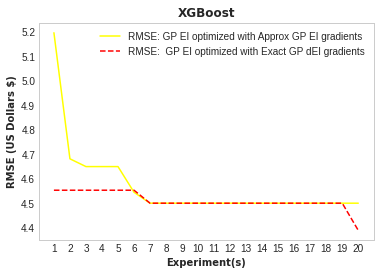

In [79]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_approx, color = 'Yellow', label='RMSE: GP EI optimized with Approx GP EI gradients')
plt.plot(min_rmse_exact, color = 'Red', label='RMSE:  GP EI optimized with Exact GP dEI gradients', ls='--')# r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('Experiment(s)', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('RMSE (US Dollars $)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_approx)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.grid(b=None)
plt.show() #visualize!


In [80]:
time_approx, time_exact


(608.4600214958191, 1241.188246011734)

In [81]:
min(min_rmse_exact), min(min_rmse_approx)


(4.388632881222052, 4.499924380514474)